In [1]:
import numpy as np
import matplotlib.pyplot as plt
from salishsea_tools import evaltools as et, viz_tools
import cmocean as cmo
import datetime as dt
import netCDF4 as nc
import matplotlib.dates as mdates
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm

%matplotlib inline

In [2]:
# path to model files:
PATH= '/results/SalishSea/nowcast-green.201812/' #path to the results file

# start and end dates for analysis: #will cut off anything before and after
start_date = dt.datetime(2015,1,1)
end_date = dt.datetime(2015,3,1)

# number of days per model file:
flen=1 #the number of days per model output file (almost always 1 for susan, elise does 10)

# dictionary mapping desired model variables to the file types where they are found
filemap={'vosaline':'grid_T','votemper':'grid_T'} 

# dictionary mapping model file types to their time resolution in hours (1 is hourly files, 24 is daily)
fdict={'ptrc_T':1,'grid_T':1} #loading data from hourly files, 1 for 1 hour (daily replace with a 24)

# results format (naming convention and storage format of the files)
# -- nowcast: files like 01jan15/SalishSea_1h_20150101_20150101_ptrc_T.nc
# -- long: files like SalishSea_1h_20150206_20150804_ptrc_T_20150427-20150506.nc, all in one directory
namfmt='nowcast'

In [3]:
# load DFO CTD data (returns pandas dataframe) - loads all the data she has in DFO archive
# SA is Absolute (actually reference) Salinity, and CT is Conservative Temperature
df1=et.loadDFOCTD(datelims=(start_date,end_date)) #this function takes the DFO data and puts it all in the right format for eval_tools, suggests craeting a function in evaltool for data you need to load commonly
print(len(df1))
df1.head()

5419


,Year,Month,Day,Hour,Lat,Lon,Z,SA,CT,Fluor,dtUTC
0,2015.0,2.0,11.0,5.296111,48.613333,-123.243833,1.983099,29.849611,8.942753,0.504,2015-02-11 05:17:46
1,2015.0,2.0,11.0,5.296111,48.613333,-123.243833,2.974641,29.852177,8.942511,0.500,2015-02-11 05:17:46
2,2015.0,2.0,11.0,5.296111,48.613333,-123.243833,3.966178,29.869012,8.941135,0.491,2015-02-11 05:17:46
3,2015.0,2.0,11.0,5.296111,48.613333,-123.243833,4.957711,29.915690,8.936661,0.482,2015-02-11 05:17:46
4,2015.0,2.0,11.0,5.296111,48.613333,-123.243833,5.949239,29.913935,8.936489,0.490,2015-02-11 05:17:46


In [4]:
# match model output to observations and return both in a dataframe
# the model variables will have their original names prefixed by mod_, eg mod_vosaline
# the observation file names are unchanged. 
data=et.matchData(data=df1,filemap=filemap, fdict=fdict, mod_start=start_date, mod_end=end_date, 
                  mod_nam_fmt=namfmt, mod_basedir=PATH, mod_flen=flen)
# 

progress: 0.0%
progress: 92.26794611551948%


In [5]:
data.head()

,Year,Month,Day,Hour,Lat,Lon,Z,SA,CT,Fluor,dtUTC,j,i,mod_vosaline,mod_votemper,k
0,2015.0,1.0,9.0,16.994444,49.328833,-124.080833,0.991487,25.146111,6.992043,NaN,2015-01-09 16:59:40,526,206,23.148205,6.303194,0
1,2015.0,1.0,9.0,16.994444,49.328833,-124.080833,2.082117,25.243427,7.082535,NaN,2015-01-09 16:59:40,526,206,25.739794,7.312764,2
2,2015.0,1.0,9.0,16.994444,49.328833,-124.080833,2.974446,25.319752,7.117362,NaN,2015-01-09 16:59:40,526,206,25.739794,7.312764,2
3,2015.0,1.0,9.0,16.994444,49.328833,-124.080833,3.965919,25.378789,7.148240,NaN,2015-01-09 16:59:40,526,206,27.279148,7.867553,3
4,2015.0,1.0,9.0,16.994444,49.328833,-124.080833,4.957386,25.423254,7.173524,NaN,2015-01-09 16:59:40,526,206,27.347662,7.893116,4


/ocean/rbeutel/MEOPAR/tools/SalishSeaTools/salishsea_tools/viz_tools.py:123: UserWarning: No contour levels were found within the data range.
  contour_lines = axes.contour(


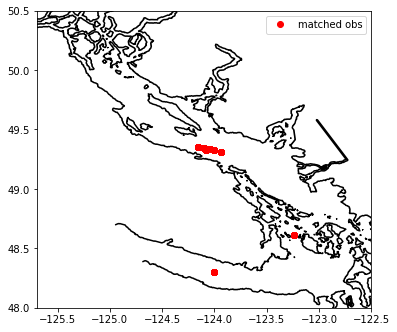

In [6]:
# plot matched data locations
fig, ax = plt.subplots(figsize = (6,6))
viz_tools.set_aspect(ax, coords = 'map')
ax.plot(data['Lon'], data['Lat'], 'ro',label='matched obs')
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
viz_tools.plot_coastline(ax, grid, coords = 'map')
ax.set_ylim(48, 50.5)
ax.legend()
ax.set_xlim(-125.7, -122.5);

In [7]:
# create dictionary of dataframe views by year
datyr=dict()
yy=np.array([ii.year for ii in data['dtUTC']])
yys=np.unique(yy)
for yr in np.unique(yy):
    datyr[yr]=data.loc[yy]

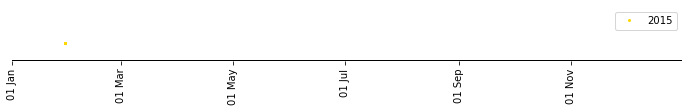

In [8]:
# plot mathced data sampling times
clist=('gold','aqua','plum','c','m','r','g','b','brown','gray')
fig,axL=plt.subplots(1,1,figsize=(12,1))
for ii, yr in enumerate(yys):
    dshift=dt.datetime(yys[0],1,1)-dt.datetime(yr,1,1)
    axL.plot(datyr[yr].dtUTC+dshift,np.zeros(np.shape(datyr[yr].dtUTC))+.1*ii,'.',
             color=clist[ii],markersize=4,label=str(yr))
axL.set_yticks(());
yearsFmt = mdates.DateFormatter('%d %b')
axL.xaxis.set_major_formatter(yearsFmt)
axL.xaxis.set_ticks([dt.datetime(int(yys[0]),1,1), dt.datetime(int(yys[0]),3,1),dt.datetime(int(yys[0]),5,1),dt.datetime(int(yys[0]),7,1),
                     dt.datetime(int(yys[0]),9,1),dt.datetime(int(yys[0]),11,1),dt.datetime(int(yys[0])+1,1,1)])
for tick in axL.get_xticklabels():
        tick.set_rotation(90)
        tick.set_horizontalalignment('center')
axL.set_ylim(-.1,.1*(len(datyr.keys())+1))
axL.set_xlim(dt.datetime(yys[0],1,1),dt.datetime(yys[0],12,31))
axL.legend()
axL.set_frame_on(False)
xmin, xmax = axL.get_xaxis().get_view_interval()
ymin, ymax = axL.get_yaxis().get_view_interval()
axL.add_artist(mpl.lines.Line2D((xmin, xmax), (ymin, ymin), color='black', linewidth=2))

#### Display stats

In [9]:
print('CT:')
et.printstats(data.loc[data.Z<15,:],'CT','mod_votemper')
print('SA:')
et.printstats(data.loc[data.Z<15,:],'SA','mod_vosaline')

CT:
  N: 243
  bias: -0.35999605360143505
  RMSE: 0.5905521915554878
  WSS: 0.7384473023813822
SA:
  N: 243
  bias: -0.1526168398159058
  RMSE: 1.0348822231362511
  WSS: 0.870339636399721


### mod vs. obs plots

Text(0.5, 1.0, '$\\Theta$ ($^{\\circ}$C)')

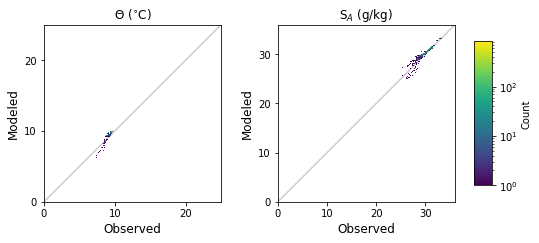

In [10]:
fig = plt.figure(figsize = (7.5,3.25))
gs1=gridspec.GridSpec(1,4,left=.08,right=.91,bottom=.1,top=.97,
                      wspace=.2,width_ratios=[1,.1,1,.1])
axT=fig.add_subplot(gs1[0,0])
axS = fig.add_subplot(gs1[0,2])
gscb=gridspec.GridSpecFromSubplotSpec(7,1,subplot_spec=gs1[:,3])
axcb = fig.add_subplot(gscb[1:-1])

axS.plot((0,36),(0,36),'k-',alpha=.2)
axT.plot((0,25),(0,25),'k-',alpha=.2)

iiT=(~np.isnan(data['CT']))&(~np.isnan(data['mod_votemper']))
iiS=(~np.isnan(data['SA']))&(~np.isnan(data['mod_vosaline']))
counts, xedges, yedges, m1=axT.hist2d(data.loc[iiT,['CT']].values.flatten(),
                                      data.loc[iiT,['mod_votemper']].values.flatten(),bins=25*3,norm=LogNorm())
counts, xedges, yedges, m2=axS.hist2d(data.loc[iiS,['SA']].values.flatten(),
                                      data.loc[iiS,['mod_vosaline']].values.flatten(),bins=36*3,norm=LogNorm())

cb=fig.colorbar(m1,cax=axcb)
cb.set_label('Count')

ntick=np.arange(0,36,10)
ntickl=[str(i) for i in ntick]
axS.set_xlim((0,36))
axS.set_ylim((0,36))
axS.set_xticks(ntick)
axS.set_xticklabels(ntickl)
axS.set_yticks(ntick)
axS.set_yticklabels(ntickl)
    
stick=np.arange(0,25,10)
stickl=[str(i) for i in stick]
axT.set_xlim((0,25))
axT.set_ylim((0,25))
axT.set_xticks(stick)
axT.set_xticklabels(stickl)
axT.set_yticks(stick)
axT.set_yticklabels(stickl)
    
for ax in (axT,axS):
    ax.set_aspect(1, adjustable='box')
    
axT.set_ylabel('Modeled',fontsize=12)
axS.set_ylabel('Modeled',fontsize=12)
axT.set_xlabel('Observed',fontsize=12)
axS.set_xlabel('Observed',fontsize=12)

axS.set_title('S$_A$ (g/kg)',fontsize=12)
axT.set_title('$\Theta$ ($^{\circ}$C)',fontsize=12)

/ocean/rbeutel/MEOPAR/tools/SalishSeaTools/salishsea_tools/viz_tools.py:123: UserWarning: No contour levels were found within the data range.
  contour_lines = axes.contour(


,Year,Month,Day,Hour,Lat,Lon,Z,SA,CT,Fluor,dtUTC,j,i,mod_vosaline,mod_votemper,k


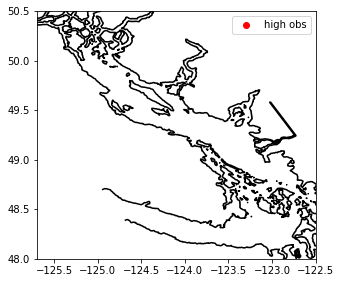

In [11]:
## where is that weird point from?
fig, ax = plt.subplots(figsize = (5,5))
viz_tools.set_aspect(ax, coords = 'map')
ax.plot(data.loc[((data.mod_votemper-data.CT)<-3),['Lon']], data.loc[((data.mod_votemper-data.CT)<-3),['Lat']], 'ro',label='high obs')
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
viz_tools.plot_coastline(ax, grid, coords = 'map')
ax.set_ylim(48, 50.5)
ax.legend()
ax.set_xlim(-125.7, -122.5);
data.loc[(data.mod_votemper-data.CT)<-3]

### Alternatively, color by depth (Z), or other variable:

Text(0.5, 1.0, '$\\Theta$ ($^{\\circ}$C)')

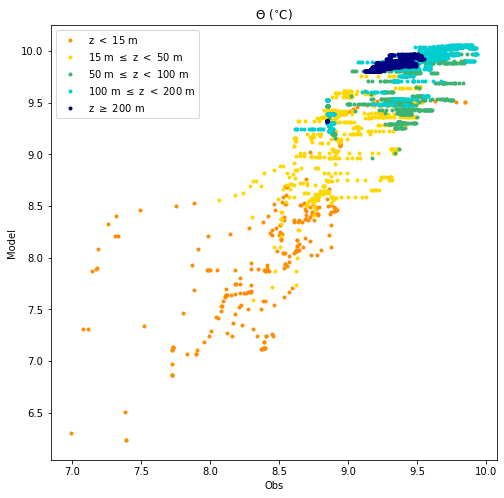

In [12]:
fig, ax = plt.subplots(figsize = (8,8))
ps=et.varvarPlot(ax,data,'CT','mod_votemper','Z',(15,50,100,200),'z','m',('darkorange','gold','mediumseagreen','darkturquoise','navy'))
ax.legend(handles=ps)
ax.set_xlabel('Obs')
ax.set_ylabel('Model')
ax.set_title('$\Theta$ ($^{\circ}$C)')